In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.plotly as py
from datetime import datetime
%matplotlib inline

## This notebook will take the raw file from mwrd on river reversals, parse it, examine it, and write it to a CSV.  The pdf is located [here](http://www.mwrd.org/irj/go/km/docs/documents/MWRD/internet/protecting_the_environment/Combined_Sewer_Overflows/pdfs/Reversals.pdf), which was then copied into a text file, cleaned up, and placed in the file in the next cell.

In [2]:
rows = open('data/reversals_raw_mwrd.txt', 'r').read().split('\n');
rows[:15]

['6/15-16/2015',
 '0',
 '997.5 ',
 '167.2 ',
 '1164.7',
 '6/30-7/1/14',
 '0',
 '362.0 ',
 '163.0 ',
 '525.0',
 '4/18-19/13 ',
 '3185.6 ',
 '6104.7 ',
 '1429.2 ',
 '10719.5']

In [3]:
# We are expecting 29 events, each represented by 5 rows
num_events = len(rows)/5
print("Number of events found: %s" % str(num_events))

Number of events found: 29.0


In [7]:
# MWRD gives us the date in many formats.  Normalize it.
def normalize_date(date_str):
    date_split = date_str.split('/')
    end_month = None    
    end_day = None
    day = date_split[1]
    if '-' in day:
        start_day = day.split('-')[0]
        if len(date_split) == 3:
            end_day = day.split('-')[1]
        else:
            end_month = day.split('-')[1]
            end_day = date_split[2]
    else:
        start_day = day
    year = int(date_split[-1])
    if year < 1985:
        if year > 20:
            year = '19%s' % year
        elif year > 9:
            year = '20%s' % year
        else:
            year = '200%s' % year
    start_date = datetime(int(year), int(date_split[0]), int(start_day))
    end_date = None
    if end_day is not None:
        if end_month is not None:
            end_date = datetime(int(year), int(end_month), int(end_day))
        else:
            end_date = datetime(int(year), int(date_split[0]), int(end_day))
    return{'start_date': start_date, 'end_date': end_date,
            'year': int(year)}
date_str = '4/18-5/1/13'
print(date_str)
normalize_date(date_str)

4/18-5/1/13


{'end_date': datetime.datetime(2013, 5, 1, 0, 0),
 'start_date': datetime.datetime(2013, 4, 18, 0, 0),
 'year': 2013}

In [10]:
# Build a dict with the attributes in the raw file, which come in 5 row blocks
events = []
for i in range(int(num_events)):
    date_str = rows[(i*5)]
    normalized_date = normalize_date(date_str)
    events.append({
                'date_raw': date_str,
                'obrien': float(rows[(i*5) + 1].strip()),
                'crcw': float(rows[(i*5) + 2].strip()),
                'wilmette': float(rows[(i*5) + 3].strip()),
                'total': float(rows[(i*5) + 4].strip()),
                'start_date': normalized_date['start_date'],
                'end_date': normalized_date['end_date'],
                'year': normalized_date['year'],
            
    })
events[:3]

[{'crcw': 997.5,
  'date_raw': '6/15-16/2015',
  'end_date': datetime.datetime(2015, 6, 16, 0, 0),
  'obrien': 0.0,
  'start_date': datetime.datetime(2015, 6, 15, 0, 0),
  'total': 1164.7,
  'wilmette': 167.2,
  'year': 2015},
 {'crcw': 362.0,
  'date_raw': '6/30-7/1/14',
  'end_date': datetime.datetime(2014, 7, 1, 0, 0),
  'obrien': 0.0,
  'start_date': datetime.datetime(2014, 6, 30, 0, 0),
  'total': 525.0,
  'wilmette': 163.0,
  'year': 2014},
 {'crcw': 6104.7,
  'date_raw': '4/18-19/13 ',
  'end_date': datetime.datetime(2013, 4, 19, 0, 0),
  'obrien': 3185.6,
  'start_date': datetime.datetime(2013, 4, 18, 0, 0),
  'total': 10719.5,
  'wilmette': 1429.2,
  'year': 2013}]

In [11]:
# Create dataframe with CSOs from river reversal here.  From this point forward, CSO refers to CSOs into the lake only.
csos = pd.DataFrame(events)
csos.head()

,crcw,date_raw,end_date,obrien,start_date,total,wilmette,year
0,997.5,6/15-16/2015,2015-06-16,0.0,2015-06-15,1164.7,167.2,2015
1,362.0,6/30-7/1/14,2014-07-01,0.0,2014-06-30,525.0,163.0,2014
2,6104.7,4/18-19/13,2013-04-19,3185.6,2013-04-18,10719.5,1429.2,2013
3,1716.2,7/24/2011,NaT,0.0,2011-07-24,2220.5,504.3,2011
4,0.0,5/29/2011,NaT,0.0,2011-05-29,107.0,107.0,2011


In [12]:
# Let's see the number of CSOs by year
csos_by_year = dict(csos['year'].value_counts())
print(csos_by_year)

{1985: 2, 1986: 1, 1987: 2, 1989: 1, 1990: 3, 1996: 1, 1997: 2, 1999: 1, 2001: 3, 2002: 1, 2007: 1, 2008: 2, 2009: 3, 2010: 1, 2011: 2, 2013: 1, 2014: 1, 2015: 1}


In [8]:
# Add the years that are missing with 0 CSOs
for year in range(1985,2016):
    if year not in csos_by_year.keys():
        csos_by_year[year] = 0
csos_by_year

{1985: 2,
 1986: 1,
 1987: 2,
 1988: 0,
 1989: 1,
 1990: 3,
 1991: 0,
 1992: 0,
 1993: 0,
 1994: 0,
 1995: 0,
 1996: 1,
 1997: 2,
 1998: 0,
 1999: 1,
 2000: 0,
 2001: 3,
 2002: 1,
 2003: 0,
 2004: 0,
 2005: 0,
 2006: 0,
 2007: 1,
 2008: 2,
 2009: 3,
 2010: 1,
 2011: 2,
 2012: 0,
 2013: 1,
 2014: 1,
 2015: 1}

<Container object of 18 artists>

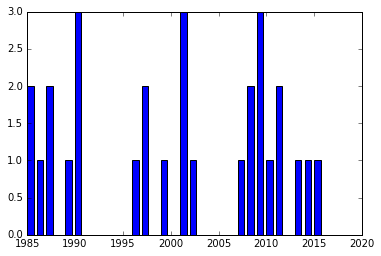

In [13]:
# Plot the number of CSOs per year
plt.bar(csos_by_year.keys(), csos_by_year.values(), 1/1.5, color="blue")

In [14]:
# We have dumped 46 billion gallons of sewage into Lake Michigan since 1985
csos[['total']].sum()

total    45920.4
dtype: float64

In [15]:
# Compare the total sewage dumped per outfall point
totals_by_lock = pd.DataFrame(csos[['crcw', 'obrien', 'wilmette']].sum(axis=0), columns=['sewage_dumped'])
totals_by_lock

,sewage_dumped
crcw,26730.7
obrien,8568.8
wilmette,10620.9


([<matplotlib.patches.Wedge at 0xa5dd4a8>,
  <matplotlib.text.Text at 0xa716a20>])

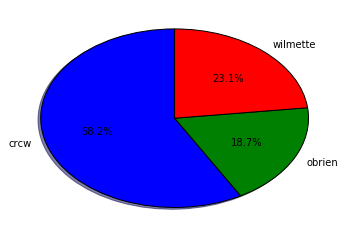

In [16]:
# Plot the percentage of total sewage dumped, per outfall point
plt.pie(totals_by_lock.sewage_dumped.values, labels=totals_by_lock.index.values,
                autopct='%1.1f%%', shadow=True, startangle=90)

In [17]:
# Find the CSOs per year per outfall point
csos_by_year_loc = csos.groupby(['year']).sum()[['crcw', 'obrien', 'wilmette']]
csos_by_year_loc.head()

,crcw,obrien,wilmette
year,,,
1985,0.0,0.0,211.3
1986,0.0,0.0,53.0
1987,986.0,0.0,989.0
1989,0.0,0.0,52.0
1990,294.0,224.0,452.5


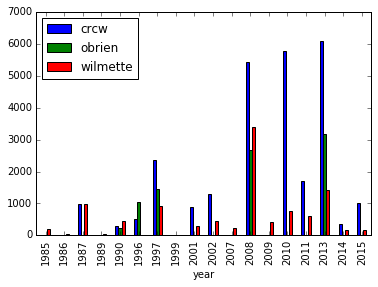

In [18]:
# Plot outfall volume per outfall point per year
csos_by_year_loc.plot(kind='bar')

In [19]:
# Create a CSV file for reversals into Lake Michigan
csos.to_csv('data/lake_michigan_reversals.csv', index=False)